In [1]:
import findspark
findspark.init()


In [2]:
from pyspark.sql import SparkSession

# Path to your SQLite JDBC driver
sqlite_jdbc_path = "/Users/alijah/Projects/smart-store-aaroe/venv/lib/sqlite-jdbc-3.49.1.0.jar"  # Replace this with the actual path

# Create Spark session with SQLite JDBC driver
spark = SparkSession.builder \
    .appName("SQLite Test") \
    .config("spark.jars", sqlite_jdbc_path) \
    .getOrCreate()

# Print Spark version to check everything is set up
print(spark.version)



25/04/12 16:17:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


3.5.5


In [3]:
# Visualization Imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_theme(style="whitegrid")

# Spark SQL Functions
from pyspark.sql.functions import col, to_date, year, quarter, month



In [4]:
from pyspark.sql import SparkSession

# Path to your SQLite JDBC driver
sqlite_jdbc_path = "/Users/alijah/Projects/smart-store-aaroe/venv/lib/sqlite-jdbc-3.49.1.0.jar"  # Update this if needed

# JDBC URL for your SQLite database (use an absolute path)
jdbc_url = "jdbc:sqlite:/Users/alijah/Projects/smart-store-aaroe/data/dw/smart_sales.db"  # Update with your actual database path

# Create Spark session with SQLite JDBC driver
spark = SparkSession.builder \
    .appName("SQLite Test") \
    .config("spark.jars", sqlite_jdbc_path) \
    .config("spark.driver.extraClassPath", sqlite_jdbc_path) \
    .config("spark.executor.extraClassPath", sqlite_jdbc_path) \
    .getOrCreate()

# Load each table into its own DataFrame
df_product = spark.read.format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "product") \
    .option("driver", "org.sqlite.JDBC") \
    .load()

df_customer = spark.read.format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "customer") \
    .option("driver", "org.sqlite.JDBC") \
    .load()

df_sale = spark.read.format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "sale") \
    .option("driver", "org.sqlite.JDBC") \
    .load()

25/04/12 16:18:06 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [6]:
# --- Step 1: Parse saledate into saledate_parsed ---
from pyspark.sql.functions import to_date, col

# Add a new column: saledate_parsed
df_sale = df_sale.withColumn("saledate_parsed", to_date(col("saledate"), "M/d/yyyy"))



In [7]:
# --- Step 2: Filter sales after January 1, 2023 ---
df_filtered = df_sale.filter(col("saledate_parsed") >= "2023-01-01")

# --- Step 3: Register temp views for SQL ---
df_filtered.createOrReplaceTempView("filtered_sales")
df_product.createOrReplaceTempView("product")


In [8]:
# Register the DataFrames as temporary views
df_sale.createOrReplaceTempView("sale")
df_customer.createOrReplaceTempView("customer")

# Spark SQL query: Total revenue per customer
df_top_customers = spark.sql("""
SELECT c.Name AS customer_name, SUM(s.saleamount) AS total_spent
FROM sale s
JOIN customer c ON s.customerid = c.CustomerID
GROUP BY c.Name
ORDER BY total_spent DESC
""")

# Show the results of the SQL query
df_top_customers.show()

# Convert to Pandas for further analysis/visualization
import pandas as pd
df_top_customers_pd = df_top_customers.toPandas()

# Optionally, preview the top 5 customers
df_top_customers_pd.head()



+----------------+------------------+
|   customer_name|       total_spent|
+----------------+------------------+
|          Dr Who|1652.1399999999999|
|    Wylie Coyote|1431.3400000000001|
|    Jason Bourne|1337.1999999999998|
|   William White|1238.7199999999998|
| Hermione Grager|           1078.98|
|   Susan Johnson|           1065.04|
|Hermione Granger|             792.8|
|   Tiffany James|            506.74|
|       Chewbacca|374.65999999999997|
|      Tony Stark|             234.6|
+----------------+------------------+



,customer_name,total_spent
0,Dr Who,1652.14
1,Wylie Coyote,1431.34
2,Jason Bourne,1337.20
3,William White,1238.72
4,Hermione Grager,1078.98


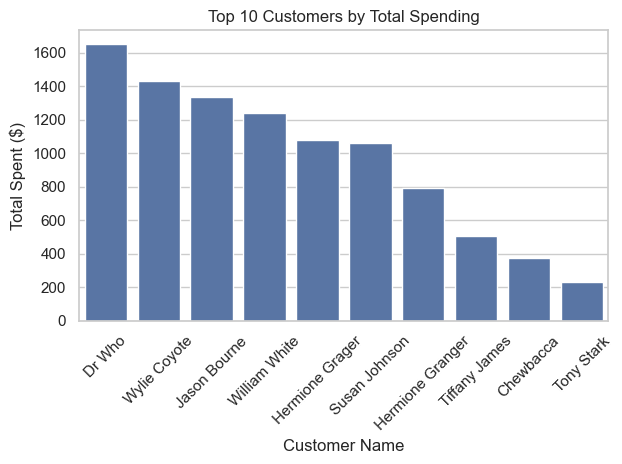

In [9]:
sns.barplot(data=df_top_customers_pd, x="customer_name", y="total_spent")
plt.xticks(rotation=45)
plt.title("Top 10 Customers by Total Spending")
plt.xlabel("Customer Name")   # <-- Just the readable label
plt.ylabel("Total Spent ($)")
plt.tight_layout()
plt.show()



In [10]:
df_product.show()
df_customer.show()
df_sale.show()


+---------+-----------+-----------+---------+-------------+-----------+
|productid|productname|   category|unitprice|stockquantity|subcategory|
+---------+-----------+-----------+---------+-------------+-----------+
|      102|     hoodie|   Clothing|     39.1|          100|Apparel    |
|      104|        hat|   Clothing|     43.1|          150|    Apparel|
|      105|   football|     Sports|    19.78|           75|    Outdoor|
|      106| controller|Electronics|    88.98|          120|Accessories|
|      107|     jacket|   Clothing|    67.02|           80|    Apparel|
|      108|  protector|Electronics|    12.56|          300|Accessories|
+---------+-----------+-----------+---------+-------------+-----------+

+----------+----------------+------+----------+-------------+----------------------+
|CustomerID|            Name|Region| Join_date|LoyaltyPoints|PreferredContactMethod|
+----------+----------------+------+----------+-------------+----------------------+
|      1001|   William W

In [11]:
# Create (or reuse) a SparkSession
spark = SparkSession.builder.appName("SmartSales").getOrCreate()

# Print the SparkSession object to confirm it's active
print(spark)


25/04/12 16:21:41 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [12]:
# Register views (safe to re-run)
df_sale.createOrReplaceTempView("sale")
df_product.createOrReplaceTempView("product")

# Dicing: Group by product category and region
df_diced = spark.sql("""
SELECT 
    p.category AS product_category, 
    s.storeid AS region,  
    SUM(s.saleamount) AS total_sales
FROM sale s
JOIN product p ON s.productid = p.productid
WHERE s.saledate >= '2023-01-01'
GROUP BY p.category, s.storeid
ORDER BY total_sales DESC
""")

df_diced.show()

+----------------+------+------------------+
|product_category|region|       total_sales|
+----------------+------+------------------+
|        Clothing|   402|1180.1399999999999|
|     Electronics|   405|1015.4000000000001|
|        Clothing|   405|             677.6|
|        Clothing|   401|            588.96|
|        Clothing|   404|             547.4|
|        Clothing|   403|391.00000000000006|
|     Electronics|   401|            364.24|
|     Electronics|   402|            340.18|
|        Clothing|   406|             324.8|
|          Sports|   405|            257.14|
|          Sports|   401|            138.46|
|     Electronics|   403|            138.16|
|     Electronics|   406|             75.36|
|          Sports|   406|             39.56|
+----------------+------+------------------+



In [14]:
# --- Filter sales after 2023-01-01 ---
df_filtered = df_sale.filter(col("saledate_parsed") >= "2023-01-01")

# --- Register temp views ---
df_filtered.createOrReplaceTempView("filtered_sales")
df_product.createOrReplaceTempView("product")


In [15]:
df_filtered = df_sale.filter(col("saledate_parsed") >= "2023-01-01")

df_drilldown = df_filtered.withColumn("year", year(col("saledate_parsed"))) \
                          .withColumn("quarter", quarter(col("saledate_parsed"))) \
                          .withColumn("month", month(col("saledate_parsed")))

df_drilldown.groupBy("year", "quarter", "month").sum("saleamount").show()


+----+-------+-----+------------------+
|year|quarter|month|   sum(saleamount)|
+----+-------+-----+------------------+
|2024|      1|    1|348.58000000000004|
|2024|      3|    7|            578.54|
|2024|      3|    8|2247.8399999999997|
|2024|      1|    3|            253.38|
|2024|      2|    6|1503.2999999999997|
|2024|      1|    2|2357.4799999999996|
|2024|      2|    5|             529.0|
|2024|      2|    4|           1782.22|
|2024|      4|   10|             301.7|
+----+-------+-----+------------------+



In [16]:
# Group sales by sale date
df_sales_trend = df_sale.groupBy("saledate_parsed").sum("saleamount") \
                        .withColumnRenamed("sum(saleamount)", "total_sales")

# Sort the result by date for plotting
df_sales_trend = df_sales_trend.orderBy("saledate_parsed")


In [17]:
# Convert sales trend to Pandas for plotting
df_sales_trend_pd = df_sales_trend.toPandas()

# (Optional) Preview to make sure it looks good
df_sales_trend_pd.head()


,saledate_parsed,total_sales
0,2024-01-06,58.88
1,2024-01-25,117.30
2,2024-01-29,172.40
3,2024-02-06,622.86
4,2024-02-08,79.58


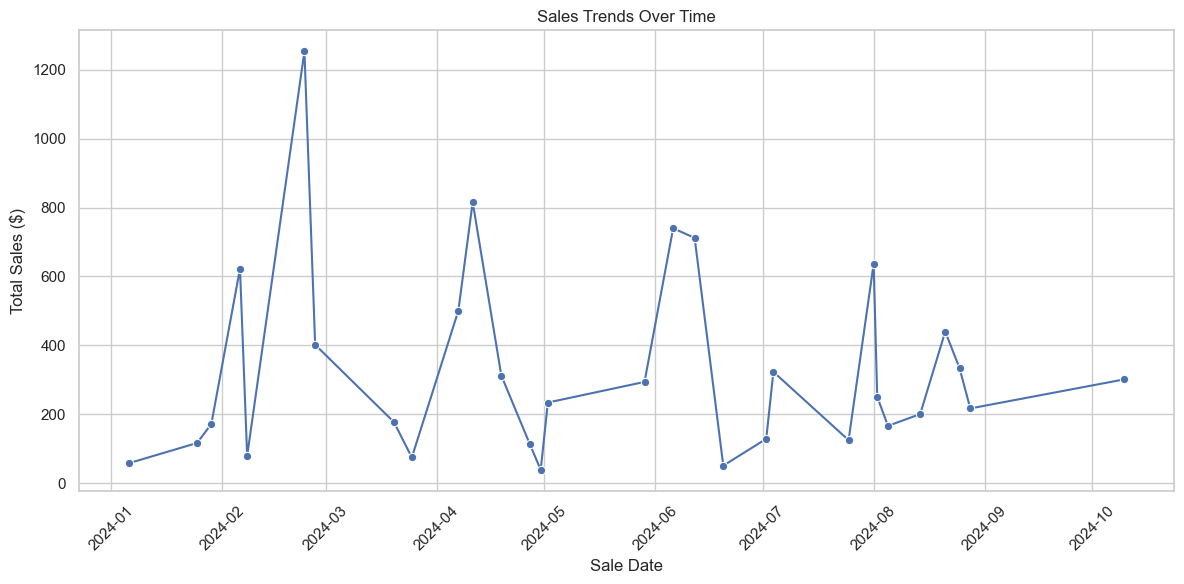

In [18]:
# Line Chart: Sales Trends Over Time
plt.figure(figsize=(12,6))
sns.lineplot(data=df_sales_trend_pd, x="saledate_parsed", y="total_sales", marker="o")
plt.xticks(rotation=45)
plt.title("Sales Trends Over Time")
plt.xlabel("Sale Date")
plt.ylabel("Total Sales ($)")
plt.tight_layout()
plt.show()


In [19]:
# View schema of your main DataFrames
df_sale.printSchema()
df_customer.printSchema()
df_product.printSchema()


root
 |-- transactionid: integer (nullable = true)
 |-- saledate: string (nullable = true)
 |-- customerid: integer (nullable = true)
 |-- productid: integer (nullable = true)
 |-- storeid: integer (nullable = true)
 |-- campaignid: integer (nullable = true)
 |-- saleamount: double (nullable = true)
 |-- discountpercent: double (nullable = true)
 |-- paymenttype: string (nullable = true)
 |-- saledate_parsed: date (nullable = true)

root
 |-- CustomerID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Join_date: string (nullable = true)
 |-- LoyaltyPoints: integer (nullable = true)
 |-- PreferredContactMethod: string (nullable = true)

root
 |-- productid: integer (nullable = true)
 |-- productname: string (nullable = true)
 |-- category: string (nullable = true)
 |-- unitprice: double (nullable = true)
 |-- stockquantity: integer (nullable = true)
 |-- subcategory: string (nullable = true)

